# TNG Preparation

This notebook takes a halo from the [TNG 300-1](https://www.tng-project.org/about/) simulation and generates simulated X-ray observations of it using [PyXSim](https://hea-www.cfa.harvard.edu/~jzuhone/pyxsim/). This observations may then be input into Bayes-X for demonstrating and testing the analysis proceedure.

## Halo Selection

Each run has 100 snapshots avaliable, at different redshifts. However, most snapshots are stored in a minified format that lacks some of the data we used to generate simulated observations. The snapshots retained in full are:

| Snap | Scale factor | Redshift |
|:----:|:------------:|:--------:|
|   2  |    0.0769    |    12    |
|   3  |    0.0833    |    11    |
|   4  |    0.0909    |    10    |
|   6  |      0.1     |     9    |
|   8  |    0.1111    |     8    |
|  11  |     0.125    |     7    |
|  13  |    0.1429    |     6    |
|  17  |    0.1667    |     5    |
|  21  |      0.2     |     4    |
|  25  |     0.25     |     3    |
|  33  |    0.3333    |     2    |
|  40  |      0.4     |    1.5   |
|  50  |      0.5     |     1    |
|  59  |    0.5882    |    0.7   |
|  67  |    0.6667    |    0.5   |
|  72  |    0.7143    |    0.4   |
|  78  |    0.7692    |    0.3   |
|  84  |    0.8333    |    0.2   |
|  91  |    0.9091    |    0.1   |
|  99  |       1      |     0    |

In [117]:
# Specify halo here
snapshot_id = 91
halo_id = 0


In [118]:
# Load TNG API key
from os import getenv

from dotenv import load_dotenv

# This looks for a .env file in this or a parent folder and
# loads environment variables from it.
# It does not override existing env vars.
load_dotenv()

# This gets it from the environment, which may have
# been modified by load_dotenv
# You could specify it here but don't commit it to git!
api_key = getenv('TNG_API_KEY')

In [119]:
from os import makedirs
from pathlib import Path
from uuid import uuid1

import requests
from tqdm.notebook import tqdm

# The files we are working with can be large so we'll make a basic
# cache to ease the load on the TNG Project servers.


def query_cache(filename: str, cache_path=Path(".cache")):
    file_path = Path(cache_path, filename)

    if file_path.is_file():
        return True, file_path
    else:
        return False, file_path


def update_cache(filename: str, content, cache_path=Path(".cache"), overwrite=False):
    if not cache_path.is_dir():
        print(f"Making cache directory at {cache_path}")
        makedirs(cache_path)

    file_path = Path(cache_path, filename)

    if file_path.exists():
        if overwrite:
            print(f"Overwriting existing cache file {file_path}.")
        else:
            raise FileExistsError(f"Cache file {file_path} already exists.")

    write_mode = "wb"
    if isinstance(content, requests.Response):
        # Read binary/text from request and access content
        if "text" in content.headers["Content-Type"]:
            write_mode = "w"
        content = content.content
    elif isinstance(content, Path):
        # If we're passed a file just move it
        # This is good for large temp files we don't want to read into memory
        print(f"Moving {content} to cache as {file_path}")
        content.rename(file_path)
        return file_path

    with file_path.open(write_mode) as f:
        print(f"Caching {file_path}")
        f.write(content)

    return file_path


def get_halo(snapshot: int, halo: int, simulation="TNG300-1"):
    base_url = f"http://www.tng-project.org/api/{simulation}/snapshots/{snapshot}/halos/{halo}/"
    headers = {"api-key": api_key}

    base_filename = f"{simulation}_snapshot{snapshot_id}_halo{halo_id}_"

    # First get info file for halo
    info_filename = base_filename + "_info.json"
    in_cache, info_path = query_cache(info_filename)

    if not in_cache:
        info_url = base_url + "info.json"
        print(f"Downloading info.json for halo from {info_url}")
        r = requests.get(info_url, headers=headers)  # type: ignore
        r.raise_for_status()  # raise exception on error
        info_path = update_cache(info_filename, r)

    # Then get the halo cutout
    halo_filename = base_filename + "_cutout.hdf5"
    in_cache, halo_path = query_cache(halo_filename)

    if not in_cache:
        tmp_file = Path(f"tmp_{uuid1()}.hdf5")
        cutout_url = base_url + "cutout.hdf5"
        print(f"Downloading cutout for halo from {cutout_url} to {tmp_file}")
        r = requests.get(cutout_url, headers=headers, stream=True)  # type: ignore
        # Fancy progress bar
        with tqdm.wrapattr(
            open(tmp_file, "wb"),
            "write",
            miniters=1,
            desc=f"Downloading cutout",
            total=int(r.headers.get("content-length", 0)),
        ) as fout:
            for chunk in r.iter_content(chunk_size=4096):
                fout.write(chunk)
        update_cache(halo_filename, tmp_file)

    return info_path, halo_path

In [120]:
info_path, halo_path = get_halo(snapshot_id, halo_id)

In [121]:
import yt

@yt.derived_field(name=("gas", "solar_metallicity"), sampling_type="particle", units="")
def _solar_metallicity(field, data):
    return data['PartType0', 'GFM_Metallicity'] / 0.0127


yt : [WARNING  ] 2023-04-26 17:03:43,038 Field ('gas', 'solar_metallicity') already exists. To override use `force_override=True`.


In [122]:
from json import load as load_json

with info_path.open() as f:
    info = load_json(f)

ds = yt.load(halo_path)

yt : [INFO     ] 2023-04-26 17:03:43,092 Calculating time from 9.096e-01 to be 3.934e+17 seconds
yt : [INFO     ] 2023-04-26 17:03:43,127 Parameters: current_time              = 3.934088884834162e+17 s
yt : [INFO     ] 2023-04-26 17:03:43,128 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-04-26 17:03:43,128 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-04-26 17:03:43,129 Parameters: domain_right_edge         = [205000. 205000. 205000.]
yt : [INFO     ] 2023-04-26 17:03:43,129 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-04-26 17:03:43,130 Parameters: current_redshift          = 0.09940180263022191
yt : [INFO     ] 2023-04-26 17:03:43,130 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2023-04-26 17:03:43,131 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2023-04-26 17:03:43,131 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2023-04-26 17:03:43,132 Parameters: hubble_const

## Plots

First we draw a couple of nice plots of the dataset. This detects the edge of the cluster (slowly) and tries to include the entire thing.

In [138]:
projection_normal = 'z'

In [139]:
# type: ignore
# Set these values here so the edge radius doesn't reset every time

# From the data specs:
# GroupPos = spatial position within the periodic box (of the particle with the minimum gravitational potential energy). Comoving coordinate.
from unyt import unyt_array, unyt_quantity
center = info['GroupPos']
center = unyt_array(center, 'kpccm/h', registry=ds.unit_registry)
r200 = unyt_quantity(info["Group_R_Crit200"], "kpccm/h", registry=ds.unit_registry)

dm = 1
r = 3 * r200
dr = 0.8 * r200

mt = ds.r[:,:,:].sum(('gas', 'mass'))
dx = mt

yt : [INFO     ] 2023-04-26 17:10:26,340 Allocating for 7.236e+07 particles

Loading particle index: 100%|██████████| 152/152 [00:00<00:00, 93990.01it/s]


In [140]:
ds.field_info['PartType0', 'GFM_Metallicity'].get_source()

'def NullFunc(field, data):\n    raise YTFieldNotFound(field.name)\n'

In [141]:
# type: ignore
# This is a crude way to find the cluster edge
sp1 = ds.sphere(center, (1, 'kpccm/h'))
while dx > 0.001*mt or abs(dr) > 50:
    r += dr
    sp2 = sp1
    sp1 = ds.sphere(center, r) 
    dx = sp1.sum(("gas", "mass")).in_units('Msun') - sp2.sum(("gas", "mass")).in_units('Msun')

    print(f"dx: {dx} at radius {r} with dr: {dr}")
    if dx == 0:
        dr = -abs(dr / 2)
    else:
        dr = min(abs(mt / dx * r), 1.5*r200)


sp = ds.sphere(center, r)

dx: 339633084663245.75 Msun at radius 6423.623999023437 kpccm/h with dr: 1352.34189453125 kpccm/h
dx: 3094610975024.75 Msun at radius 8959.26505126953 kpccm/h with dr: 2535.6410522460938 kpccm/h
dx: 0.0 Msun at radius 11494.906103515625 kpccm/h with dr: 2535.6410522460938 kpccm/h
dx: 0.0 Msun at radius 10227.085577392578 kpccm/h with dr: -1267.8205261230469 kpccm/h
dx: 0.0 Msun at radius 9593.175314331054 kpccm/h with dr: -633.9102630615234 kpccm/h
dx: 0.0 Msun at radius 9276.220182800293 kpccm/h with dr: -316.9551315307617 kpccm/h
dx: 0.0 Msun at radius 9117.742617034912 kpccm/h with dr: -158.47756576538086 kpccm/h
dx: 0.0 Msun at radius 9038.503834152221 kpccm/h with dr: -79.23878288269043 kpccm/h


yt : [INFO     ] 2023-04-26 17:10:46,333 xlim = 38785.658239 47824.162073
yt : [INFO     ] 2023-04-26 17:10:46,334 ylim = 43829.494177 52867.998011
yt : [INFO     ] 2023-04-26 17:10:46,335 xlim = 38785.652972 47824.155579
yt : [INFO     ] 2023-04-26 17:10:46,335 ylim = 43829.488225 52867.990831
yt : [INFO     ] 2023-04-26 17:10:46,337 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



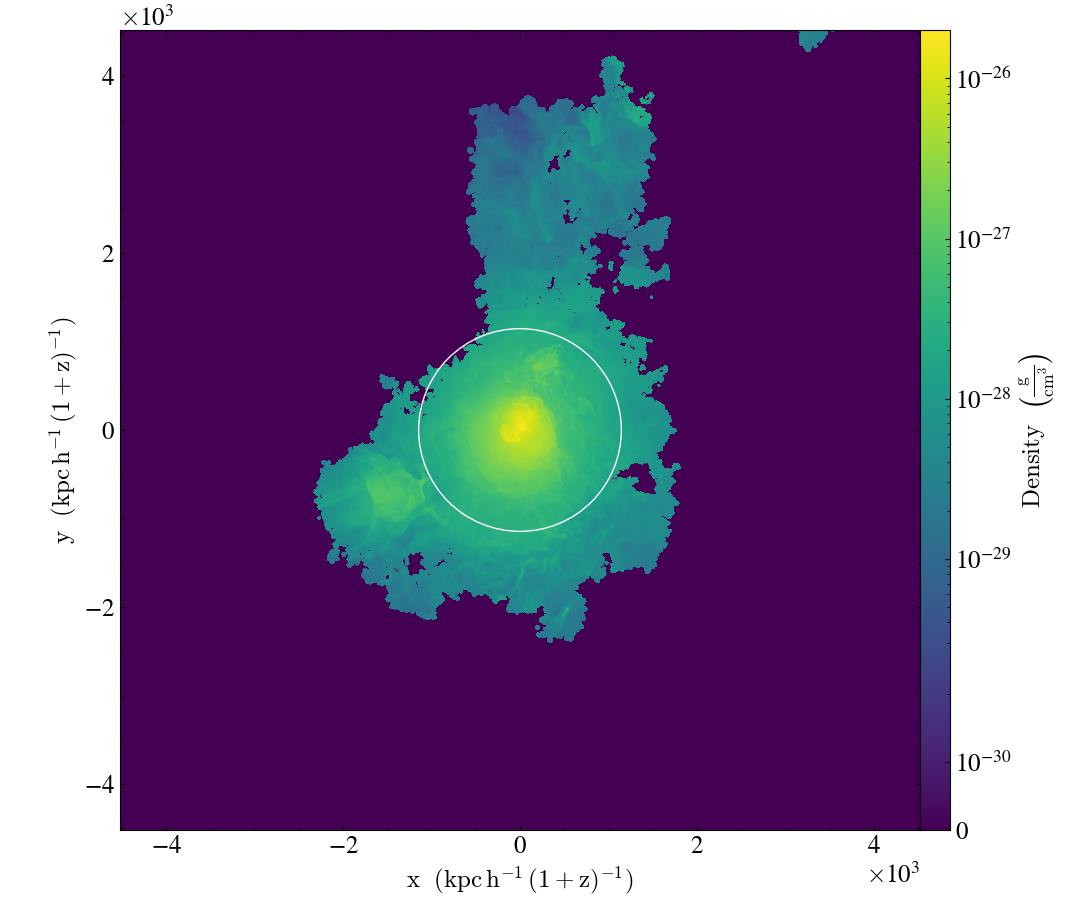

In [142]:
# type: ignore
from yt.visualization.plot_window import SlicePlot
density_slc = SlicePlot(ds, projection_normal, [("gas", "density")], center=center, width=r)

density_slc.annotate_sphere(center, radius=r200)

density_slc.set_cmap(('gas', 'density'), 'viridis')
density_slc.show()
# density_slc.save()

yt : [INFO     ] 2023-04-26 17:10:59,299 xlim = 38785.658239 47824.162073
yt : [INFO     ] 2023-04-26 17:10:59,300 ylim = 43829.494177 52867.998011
yt : [INFO     ] 2023-04-26 17:10:59,301 xlim = 38785.652972 47824.155579
yt : [INFO     ] 2023-04-26 17:10:59,301 ylim = 43829.488225 52867.990831
yt : [INFO     ] 2023-04-26 17:10:59,302 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



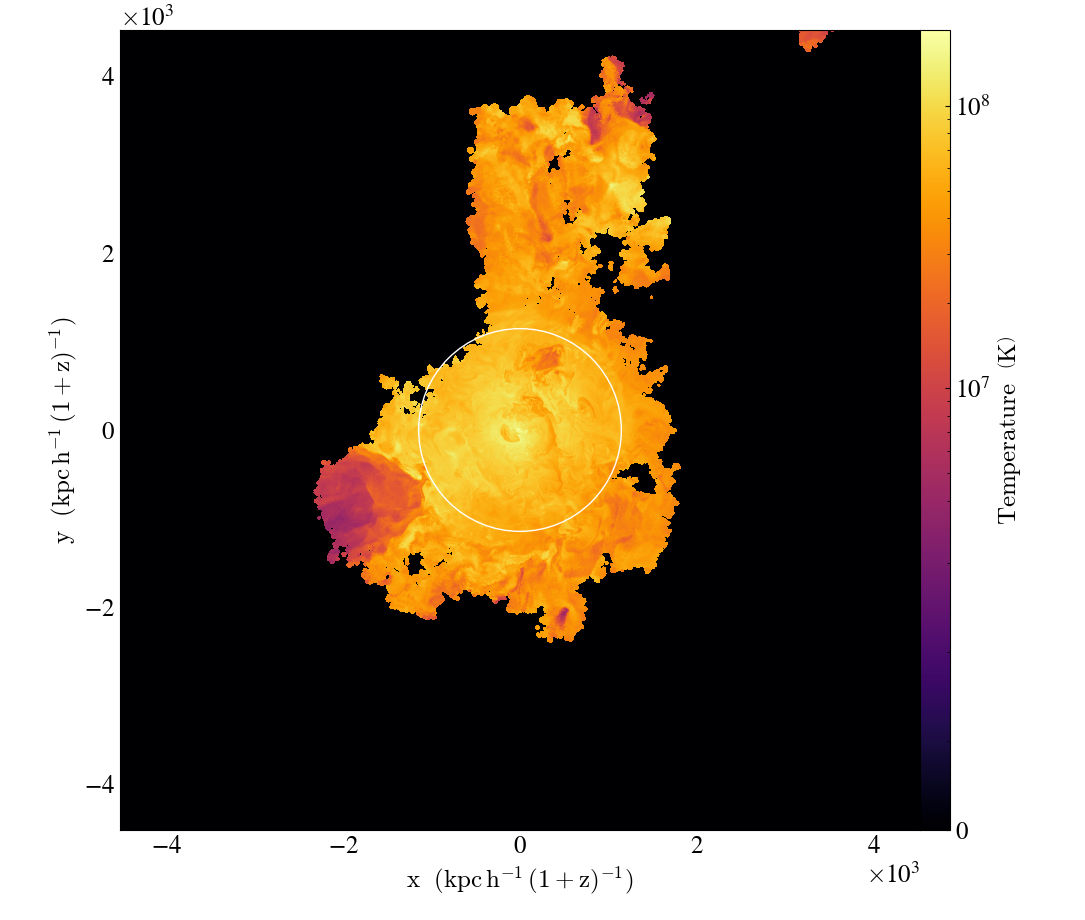

In [143]:
# type: ignore
temperature_slc = SlicePlot(ds, projection_normal, [("gas", "temperature")], center=center, width=r)

temperature_slc.annotate_sphere(center, radius=r200)

temperature_slc.set_cmap(('gas', 'temperature'), 'inferno')
temperature_slc.show()
# temperature_slc.save()

yt : [INFO     ] 2023-04-26 17:11:12,064 xlim = 38785.658239 47824.162073
yt : [INFO     ] 2023-04-26 17:11:12,065 ylim = 43829.494177 52867.998011
yt : [INFO     ] 2023-04-26 17:11:12,066 xlim = 38785.652972 47824.155579
yt : [INFO     ] 2023-04-26 17:11:12,067 ylim = 43829.488225 52867.990831
yt : [INFO     ] 2023-04-26 17:11:12,067 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
Initializing refined index:  63%|██████▎   | 96/152 [07:39<04:28,  4.79s/it]



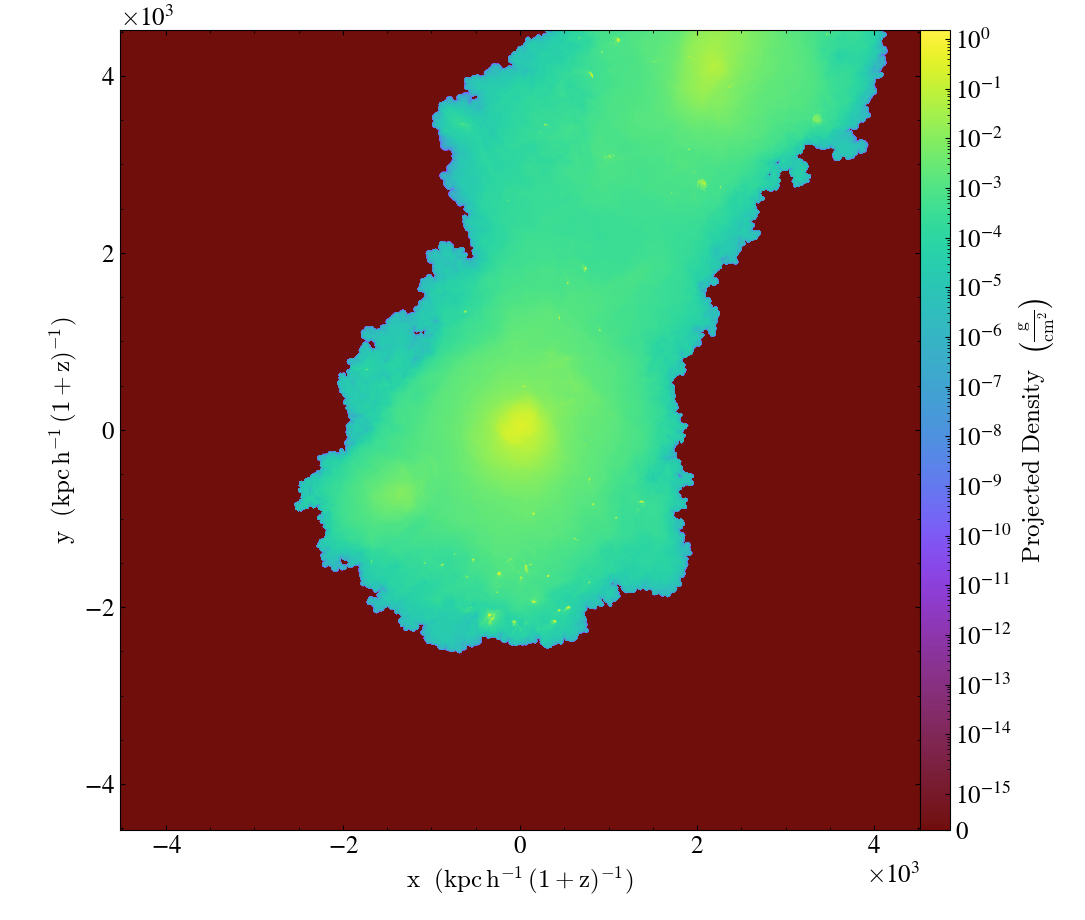

In [144]:
from yt import ProjectionPlot
proj = ProjectionPlot(ds, projection_normal, ("gas", "density"), center=center, width=r)
proj.show()

In [145]:
import pyxsim
import soxs

In [146]:
energy_range = (0.3, 7.0)
nbins = 400 # 1100 for detail, but slow
prefix = 'tng_'
source_exp_time = (300., "ks") # exposure time
area = (1000, "cm**2") # collecting area
redshift = ds.current_redshift # type: ignore

In [147]:
from math import atan, sqrt

pos = (atan(center[0]/center[2]), atan(center[1] / sqrt(center[0]**2 + center[2]**2))) # (RA, Dec)

In [148]:
var_elem = {
    elem: ("gas", f"{elem}_fraction")
    for elem in
    ["C", "Fe", "H", "He", "Mg", "N", "Ne", "O", "Si"]
}

# Sources uses larger energy range than observations
# Convert metallicity to solar values
source_model = pyxsim.CIESourceModel('apec', emin=0.1, emax=11.0, nbins=nbins, Zmet=('gas', 'solar_metallicity'), var_elem=var_elem)

pyxsim : [INFO     ] 2023-04-26 17:11:27,415 kT_min = 0.025 keV
pyxsim : [INFO     ] 2023-04-26 17:11:27,415 kT_max = 64 keV


In [149]:
xray_fields = source_model.make_source_fields(ds, *energy_range)
print(xray_fields)

pyxsim : [INFO     ] 2023-04-26 17:11:27,447 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-04-26 17:11:27,447 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

[('gas', 'xray_emissivity_0.3_7.0_keV'), ('gas', 'xray_luminosity_0.3_7.0_keV'), ('gas', 'xray_photon_emissivity_0.3_7.0_keV')]


In [150]:
n_photons, n_cells = pyxsim.make_photons(prefix + "photons", sp, redshift, area, source_exp_time, source_model)

pyxsim : [INFO     ] 2023-04-26 17:11:30,633 Cosmology: h = 0.6774, omega_matter = 0.3089, omega_lambda = 0.6911
pyxsim : [INFO     ] 2023-04-26 17:11:30,634 Using emission measure field '('gas', 'emission_measure')'.
pyxsim : [INFO     ] 2023-04-26 17:11:30,634 Using temperature field '('gas', 'temperature')'.


Preparing spectrum table :   0%|          | 0/138 [00:00<?, ?it/s]

Processing cells/particles :   0%|          | 0/28834570 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2023-04-26 17:17:20,038 Finished generating photons.
pyxsim : [INFO     ] 2023-04-26 17:17:20,038 Number of photons generated: 41743135
pyxsim : [INFO     ] 2023-04-26 17:17:20,039 Number of cells with photons: 12096414


In [151]:
n_events = pyxsim.project_photons(prefix + "photons", prefix + "events", projection_normal, pos, absorb_model="tbabs", nH=0.022)
events = pyxsim.EventList(prefix + "events.h5")
events.write_to_simput(prefix, overwrite=True)

pyxsim : [INFO     ] 2023-04-26 17:17:20,071 Foreground galactic absorption: using the tbabs model and nH = 0.022.


Projecting photons from cells/particles :   0%|          | 0/12096414 [00:00<?, ?it/s]

pyxsim : [INFO     ] 2023-04-26 17:17:30,743 Detected 23626786 events.
soxs : [WARNING  ] 2023-04-26 17:17:31,481 Overwriting tng__phlist.fits.
soxs : [INFO     ] 2023-04-26 17:17:32,069 Writing source 'tng_' to tng__phlist.fits.


In [152]:
bg_exp_time = (300., "ks")

In [153]:
soxs.make_background_file(prefix + "bg.fits", bg_exp_time, "chandra_acisi_cy0", pos, overwrite=True)
soxs.instrument_simulator(prefix + "_simput.fits", prefix + "obs_evt.fits", bg_exp_time, "chandra_acisi_cy0",
                          pos, overwrite=True, bkgnd_file=prefix+'bg.fits')
soxs.write_image(prefix + "obs_evt.fits", prefix + "obs_img.fits", emin=0.3, emax=7.0, overwrite=True)

soxs : [INFO     ] 2023-04-26 17:17:33,661 Adding in point-source background.
soxs : [INFO     ] 2023-04-26 17:17:34,149 Detecting events from source ptsrc_bkgnd.
soxs : [INFO     ] 2023-04-26 17:17:34,150 Applying energy-dependent effective area from acisi_aimpt_cy0.arf.
soxs : [INFO     ] 2023-04-26 17:17:34,165 Pixeling events.
soxs : [INFO     ] 2023-04-26 17:17:34,176 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2023-04-26 17:17:34,221 40278 events were detected from the source.
soxs : [INFO     ] 2023-04-26 17:17:34,223 Scattering energies with RMF acisi_aimpt_cy0.rmf.


Scattering energies :   0%|          | 0/40278 [00:00<?, ?it/s]

soxs : [INFO     ] 2023-04-26 17:17:34,364 Generated 40278 photons from the point-source background.
soxs : [INFO     ] 2023-04-26 17:17:34,364 Adding in astrophysical foreground.


Convolving spectrum :   0%|          | 0/937 [00:00<?, ?it/s]

soxs : [INFO     ] 2023-04-26 17:17:34,851 Adding in instrumental background.
soxs : [INFO     ] 2023-04-26 17:17:34,883 Making 16088 events from the galactic foreground.
soxs : [INFO     ] 2023-04-26 17:17:34,883 Making 364147 events from the instrumental background.
soxs : [INFO     ] 2023-04-26 17:17:34,906 Writing events to file tng_bg.fits.
soxs : [INFO     ] 2023-04-26 17:17:35,012 Making observation of source in tng_obs_evt.fits.
soxs : [INFO     ] 2023-04-26 17:17:35,965 Detecting events from source tng_.
soxs : [INFO     ] 2023-04-26 17:17:35,966 Applying energy-dependent effective area from acisi_aimpt_cy0.arf.
soxs : [INFO     ] 2023-04-26 17:17:38,451 Pixeling events.
soxs : [INFO     ] 2023-04-26 17:17:39,647 Scattering events with a multi_image-based PSF.
soxs : [INFO     ] 2023-04-26 17:17:44,052 3731408 events were detected from the source.
soxs : [INFO     ] 2023-04-26 17:17:44,905 Scattering energies with RMF acisi_aimpt_cy0.rmf.


Scattering energies :   0%|          | 0/3731408 [00:00<?, ?it/s]

soxs : [INFO     ] 2023-04-26 17:17:46,786 Adding background events from the file tng_bg.fits.
soxs : [INFO     ] 2023-04-26 17:17:46,793 Adding 420513 background events from tng_bg.fits.
soxs : [INFO     ] 2023-04-26 17:17:46,849 Writing events to file tng_obs_evt.fits.
soxs : [INFO     ] 2023-04-26 17:17:47,965 Observation complete.


(<Figure size 1000x1000 with 2 Axes>, <WCSAxes: >)

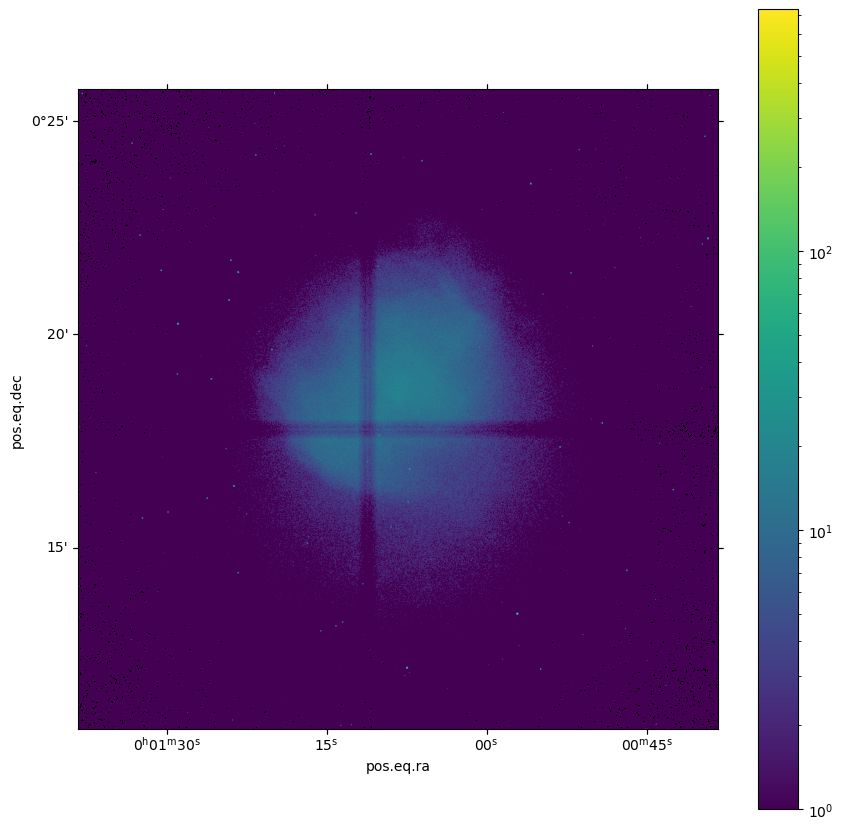

In [154]:
soxs.plot_image(prefix + "obs_img.fits", stretch='log', cmap='viridis', width=0.25)